---
title: 'Data processing using OpenPose-pose2sim coordinates'
---

In the previous notebook, we have ran pose estimation on the trial videos (OpenPose), and triangulated the coordinates to get 3D coordinates for each trial (Pose2sim).

In this script, we will clean the data, and extract further information (such as speed, acceleration, etc.). 

In [8]:
# packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import random

curfolder = os.getcwd()

# files to work with
mtfolder = curfolder + '\\..\\..\\01_MotionCapture\\OpenPose_pose2sim\\projectdata\\'

# folders to save the processed data
MTfolder_processed = curfolder + '\\TS_processed\\'

# create the folder if it does not exist
if not os.path.exists(MTfolder_processed):
    os.makedirs(MTfolder_processed)

In [10]:
MTtotrack = glob.glob(mtfolder + '*/P*/*', recursive=True)

# get rid of all the folders that are not the ones we want to track, like .sto files
MTtotrack = [x for x in MTtotrack if 'txt' not in x]
MTtotrack = [x for x in MTtotrack if 'toml' not in x]


MTfiles_all = []

for folder in MTtotrack:
    # last element is trialid
    trialid = folder.split('\\')[-1]
    
    # get all csv files in the folder
    csvfiles = glob.glob(folder + '\\**\\*.csv', recursive=True)
    # keep only the ones that have butterworth in the name - those are filtered with native Pose2sim function
    csvfiles = [x for x in csvfiles if 'butterworth' in x]
    butterfile = csvfiles[0]
    # append to list with trialid
    MTfiles_all.append([trialid, butterfile])

MTfiles_all

[['0_1_20_p0',
  'c:\\Users\\kadava\\Documents\\Github\\MotionTrackingPipeline_Workshop_ZAS2025\\02_DataProcessing\\OpenPose\\..\\..\\01_MotionCapture\\OpenPose_pose2sim\\projectdata\\Session_0_1\\P0\\0_1_20_p0\\pose-3d\\0_1_20_p0_0-232_filt_butterworth.trc.csv'],
 ['0_1_21_p0',
  'c:\\Users\\kadava\\Documents\\Github\\MotionTrackingPipeline_Workshop_ZAS2025\\02_DataProcessing\\OpenPose\\..\\..\\01_MotionCapture\\OpenPose_pose2sim\\projectdata\\Session_0_1\\P0\\0_1_21_p0\\pose-3d\\0_1_21_p0_0-215_filt_butterworth.trc.csv'],
 ['0_1_22_p0',
  'c:\\Users\\kadava\\Documents\\Github\\MotionTrackingPipeline_Workshop_ZAS2025\\02_DataProcessing\\OpenPose\\..\\..\\01_MotionCapture\\OpenPose_pose2sim\\projectdata\\Session_0_1\\P0\\0_1_22_p0\\pose-3d\\0_1_22_p0_0-274_filt_butterworth.trc.csv'],
 ['0_1_23_p0',
  'c:\\Users\\kadava\\Documents\\Github\\MotionTrackingPipeline_Workshop_ZAS2025\\02_DataProcessing\\OpenPose\\..\\..\\01_MotionCapture\\OpenPose_pose2sim\\projectdata\\Session_0_1\\P0\\0_1_

In [11]:
# function to check different smoothing windows and orders
def check_smooth_strength(df, windows, orders, keytoplot):

    # prepare new df
    df_smooth = pd.DataFrame()

    for win in windows:
        for ord in orders:
            df_smooth[keytoplot + '_savgol' + str(win) + '_' + str(ord)] = scipy.signal.savgol_filter(df[keytoplot], win, ord)

    # make R_Hand_x from df_sample a list
    keytoplot_unsmoothed = df[keytoplot].tolist()

    # load these values into df_smooth as a new column
    df_smooth[keytoplot] = keytoplot_unsmoothed

    # plot keytoplot in all strngths
    colstoplot = [x for x in df_smooth.columns if keytoplot in x]
    plt.figure()
    for col in colstoplot:
        plt.plot(df_smooth[col], label=col)
    plt.legend()
    plt.show()

Here we can see a timeseries of vertical dimension of the left knee. Each color represents the timeseries in different smoothed version, pink one is the raw signal (which is smoothed only with the Butterworth 10Hz cut-off filter). The first number in the legend corresponds to window length and the second number to polynomial order.

c:\Users\kadava\Documents\Github\MotionTrackingPipeline_Workshop_ZAS2025\02_DataProcessing\OpenPose\..\..\01_MotionCapture\OpenPose_pose2sim\projectdata\Session_0_1\P0\0_1_25_p0\pose-3d\0_1_25_p0_0-370_filt_butterworth.trc.csv


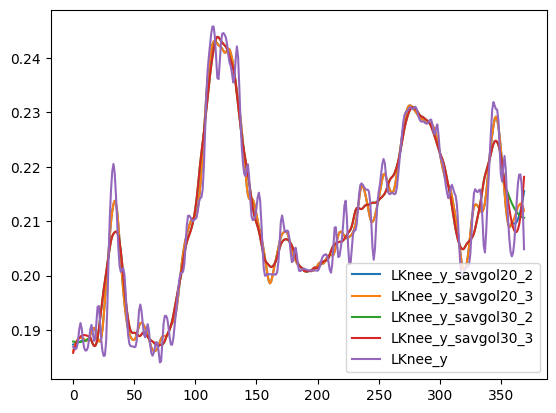

In [13]:
print(MTfiles_all[5][1])
sample = pd.read_csv(MTfiles_all[5][1], sep=',')

windows = [20, 30] # list possible window
orders = [2, 3] # list possible orders

check_smooth_strength(sample, windows, orders, 'LKnee_y')

Here we can see the same thing for wrist.

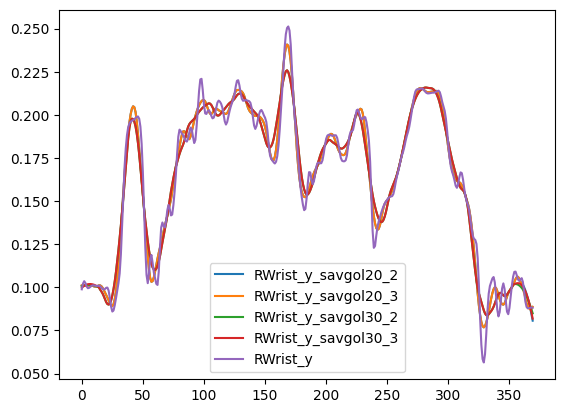

In [14]:
sample = pd.read_csv(MTfiles_all[5][1], sep=',')

windows = [20, 30] # list possible window
orders = [2, 3] # list possible orders

check_smooth_strength(sample, windows, orders, 'RWrist_y')

For both, 3rd order Savitzky-Golay filter with window of 320 ms seems to be a good choice. We will use it both for raw coordinates as well as for the derivatives.

Further, we obtain the first, second and third derivative of the timeseries, namely speed, acceleration, and jerk. 

Lastly, to be able to work with timeseries that represent bigger segment of body than a single joint, we aggregate the kinematic derivatives for each body group (i.e., head, upperbody, arms, lowerbody) by computing euclidian sum over every derivative belonging to the group. This gives us, for instance, a measure for arm speed that represents a sum of speeds of all keypoints associated with the arm (i.e., wrist, elbow, shoulder, index)

In [16]:
# function to get euclidian sum of associated keypoints
def aggregate_keypoints(df, measurement, finalcolname, use):

    if use == 'kinematics':
        # group keypoints that belong together
        lowerbodycols = ['RHip', 'LHip']
        legcols = ['RKnee', 'RAnkle', 'LAnkle', 'LKnee', 'RHeel', 'LHeel']
        headcols = ['Head', 'Neck', 'Nose']
        armcols = ['RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'RIndex', 'LIndex']

        groups = [lowerbodycols, legcols, headcols, armcols]

    elif use == 'angles':
        pelviscols = ['pelvis']
        spinecols = ['L5_S1', 'L4_L5', 'L3_L4', 'L2_L3', 'L1_L2', 'L1_T12']
        lowerbodycols = ['pelvis', 'hip']
        legcols = ['knee', 'ankle', 'subtalar']
        headcols = ['neck']
        armcols = ['arm', 'elbow', 'wrist', 'pro_sup']

        groups = [lowerbodycols, legcols, headcols, armcols, pelviscols, spinecols]

    # make subdf only with speed
    subdf = df[[x for x in df.columns if measurement in x]]

    # loop through each joint group
    for group in groups:
        # get cols
        cols = [x for x in subdf.columns if any(y in x for y in group)]
        subdf_temp = subdf[cols]

        for index, row in subdf_temp.iterrows():
            # get all values of that row
            values = row.values
            # calculate euclidian sum
            euclidian_sum = np.sqrt(np.sum(np.square(values))) ## FLAGGED: possibly normalize
            # get a name for new col
            if group == lowerbodycols:
                colname = 'lowerbody'
            elif group == legcols:
                colname = 'leg'
            elif group == headcols:
                colname = 'head'
            elif group == armcols:
                colname = 'arm'
            elif group == pelviscols:
                colname = 'pelvis'
            elif group == spinecols:
                colname = 'spine'
                

            df.loc[index, colname + finalcolname] = euclidian_sum

    return df


# get kinematic derivatives
def get_derivatives(df, sr, upperbodycols, lowerbodycols, use):

    mtcols = df.columns
    if use == 'kinematics':
        # get rid of cols that are not x, y or z
        mtcols = [x for x in mtcols if '_x' in x or '_y' in x or '_z' in x]
    

        # prepare cols for speed
        cols = [x.split('_')[0] for x in mtcols]
        colsforspeed = list(set(cols))

        # for each unique colname (cols), calculate speed 
        for col in colsforspeed:
            # get x and y columns
            x = df[col + '_x']
            y = df[col + '_y']
            z = df[col + '_z'] # note that y and z are flipped
            # calculate speed
            speed = np.insert(np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2),0,0)
            # multiply the values by sr, because now we have values in m/(s/sr)
            speed = speed*sr

            # smooth
            speed = scipy.signal.savgol_filter(speed, 20, 3)

            # if the col contains wrist, we will alco calculate the vertical velocity (z dimension)
            if 'Wrist' in col:
                verticvel = np.insert(np.diff(z), 0, 0)
                verticvel = verticvel*sr
                verticvel = scipy.signal.savgol_filter(verticvel, 20, 3)

            # derive acceleration	
            acceleration = np.insert(np.diff(speed), 0, 0)
            acceleration = scipy.signal.savgol_filter(acceleration, 20, 3)

            # derive jerk
            jerk = np.insert(np.diff(acceleration), 0, 0)
            jerk = scipy.signal.savgol_filter(jerk, 20, 3)

            # new_data
            new_data = pd.DataFrame({col + '_speed': speed, col + '_acc': acceleration, col + '_jerk': jerk})
            df = pd.concat([df, new_data], axis=1)

    elif use == 'angles':
        # get rid of cols that are not angles (so skip time)
        mtcols = mtcols[1:]

        # derive speed
        for col in mtcols:
            speed = np.insert(np.diff(df[col]), 0, 0)
            speed = speed*sr
            speed = scipy.signal.savgol_filter(speed, 20, 3)

            # derive acceleration
            acceleration = np.insert(np.diff(speed), 0, 0)
            acceleration = scipy.signal.savgol_filter(acceleration, 20, 3)
            
            # derive jerk
            jerk = np.insert(np.diff(acceleration), 0, 0)
            jerk = scipy.signal.savgol_filter(jerk, 20, 3)

            # new_data
            new_data = pd.DataFrame({col + '_speed': speed, col + '_acc': acceleration, col + '_jerk': jerk})
            df = pd.concat([df, new_data], axis=1)

    return df

In [17]:
# upper body cols
upperbodycols = ['Head', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'Nose', 'RIndex', 'LIndex']
# lower body cols
lowerbodycols = ['RHip', 'RKnee', 'RAnkle', 'RHeel' 'LHip', 'LKnee', 'LAnkle', 'LHeel']

for folder in MTtotrack:
    # last element is trialid
    trialid = folder.split('\\')[-1]
    print('working on:' + trialid)
    
    # get all csv files in the folder
    csvfiles = glob.glob(folder + '/**/*.csv', recursive=True)
    # keep only the ones that have butterworth in the name
    csvfiles = [x for x in csvfiles if 'butterworth' in x]
    butterfile = csvfiles[0]

    # load it
    mt = pd.read_csv(butterfile)

    # the mt is missing 0 ms timepoint, so we need to create a row that copies the first row of mt and time = 0
    padrow = mt.iloc[0].copy()
    padrow['Time'] = 0

    # concatenate it to the beginning of mt 
    mt = pd.concat([pd.DataFrame(padrow).T, mt], ignore_index=True)

    # keep only cols of interest
    colstokeep = ["Time", "RHip", "RKnee", "RAnkle", "RHeel", "LHip", "LKnee", "LAnkle", "LHeel", "Neck", "Head", "Nose", "RShoulder", "RElbow", "RWrist", "RIndex", "LShoulder", "LElbow", "LWrist",
    "LIndex",
]
    mt = mt[[col for col in mt.columns if any(x in col for x in colstokeep)]]

    # flip y and z dimension as they are reversed from OpenPose/Pose2sim

    # if col has _y in it, replace it by _temp
    mt.columns = [x.replace('_y', '_temp') for x in mt.columns]
    # replace _z by _y
    mt.columns = [x.replace('_z', '_y') for x in mt.columns]
    # replace _temp by _z
    mt.columns = [x.replace('_temp', '_z') for x in mt.columns]

    ####### SMOOTHING ######

    # smooth all columns except time with savgol
    mtcols = mt.columns
    colstosmooth = mtcols[:-1]

    mt_smooth = pd.DataFrame()

    for col in colstosmooth:
        mt_smooth[col] = scipy.signal.savgol_filter(mt[col], 20, 3)
        # and put them all to cms
        mt_smooth[col] = mt_smooth[col]*100

    # add back time column
    mt_smooth['Time'] = mt['Time']

    # get sampling rate
    sr = 1/np.mean(np.diff(mt['Time']))

    ###### DERIVATIVES ######

    # get kinematic derivatives
    mt_smooth = get_derivatives(mt_smooth, sr, upperbodycols, lowerbodycols, 'kinematics')

    ###### AGGREGATING ######

    # getting aggreagated sums for groups of cols
    mt_smooth = aggregate_keypoints(mt_smooth, 'speed', '_speedKin_sum', 'kinematics')
    mt_smooth = aggregate_keypoints(mt_smooth, 'acc', '_accKin_sum', 'kinematics')
    mt_smooth = aggregate_keypoints(mt_smooth, 'jerk', '_jerkKin_sum', 'kinematics')

    # add trialid
    mt_smooth['TrialID'] = trialid
    # convert time to ms
    mt_smooth['Time'] = mt_smooth['Time']*1000
    # write to csv
    mt_smooth.to_csv(MTfolder_processed + '/mt_' + trialid + '.csv', index=False)

working on:0_1_20_p0
working on:0_1_21_p0
working on:0_1_22_p0
working on:0_1_23_p0
working on:0_1_24_p0
working on:0_1_25_p0
working on:0_1_26_p0
working on:0_1_29_p1
working on:0_1_30_p1
working on:0_1_31_p1
working on:0_1_32_p1
working on:0_1_33_p1
working on:0_1_34_p1
working on:0_1_35_p1


Here is an example of the file

In [18]:
#| echo: false

mtfiles = glob.glob(MTfolder_processed + '*.csv')
# Keep only mt_
mtfiles = [x for x in mtfiles if 'mt_' in x]
mtfile = random.choice(mtfiles)

# Display
mt = pd.read_csv(mtfile)
mt.head(15)

,RHip_x,RHip_z,RHip_y,RKnee_x,RKnee_z,RKnee_y,RAnkle_x,RAnkle_z,RAnkle_y,RHeel_x,...,arm_speedKin_sum,lowerbody_accKin_sum,leg_accKin_sum,head_accKin_sum,arm_accKin_sum,lowerbody_jerkKin_sum,leg_jerkKin_sum,head_jerkKin_sum,arm_jerkKin_sum,TrialID
0,12.170070,19.344391,2.792221,13.741268,17.449391,-37.117305,16.260284,20.190439,-75.237095,17.058748,...,16.905359,0.912118,2.529660,2.311609,1.718133,0.623161,0.976856,0.122756,0.297673,0_1_34_p1
1,12.250680,19.335767,2.866139,13.746131,17.515144,-36.928420,16.273501,20.212318,-75.055737,16.905496,...,17.624256,0.436982,2.738182,2.144813,1.380072,0.486977,0.722320,0.154892,0.347426,0_1_34_p1
2,12.317881,19.351914,2.899875,13.754547,17.552980,-36.854347,16.274787,20.263112,-74.931610,16.789242,...,18.026375,0.867568,3.153687,1.905010,1.196514,0.360797,0.561287,0.307395,0.401953,0_1_34_p1
3,12.372711,19.388984,2.897128,13.765832,17.565836,-36.881451,16.265728,20.338144,-74.858624,16.706071,...,18.002181,1.242039,3.430945,1.609498,1.150568,0.247254,0.490106,0.408533,0.432289,0_1_34_p1
4,12.416209,19.443129,2.861598,13.779304,17.556653,-36.996096,16.247914,20.432738,-74.830685,16.652063,...,17.542932,1.436802,3.490105,1.277825,1.196575,0.151622,0.481265,0.458807,0.433232,0_1_34_p1
5,12.449412,19.510502,2.796987,13.794279,17.528371,-37.184647,16.222932,20.542214,-74.841704,16.623301,...,16.692514,1.467952,3.341338,0.933943,1.283366,0.090384,0.496231,0.464356,0.406963,0_1_34_p1
6,12.473358,19.587253,2.706994,13.810074,17.483929,-37.433466,16.192369,20.661896,-74.885588,16.615869,...,15.523692,1.364416,3.027370,0.615846,1.373876,0.094336,0.508500,0.432074,0.358769,0_1_34_p1
7,12.489087,19.669535,2.595319,13.826004,17.426267,-37.728920,16.157814,20.787107,-74.956245,16.625848,...,14.126485,1.158093,2.608911,0.415027,1.445319,0.132774,0.506182,0.369158,0.296918,0_1_34_p1
8,12.497635,19.753501,2.465664,13.841387,17.358324,-38.057372,16.120855,20.913168,-75.047585,16.649320,...,12.602517,0.882655,2.164917,0.466401,1.483487,0.166037,0.486067,0.283255,0.235972,0_1_34_p1
9,12.500042,19.835302,2.321729,13.855538,17.283039,-38.405186,16.083080,21.035403,-75.153515,16.682370,...,11.062319,0.575608,1.797716,0.660573,1.479044,0.182556,0.449676,0.183612,0.204307,0_1_34_p1


Let's check one file to see how the data looks like by plotting RWrist and its kinematics, and also the euclidian sum for the whole arm along with it (as dashed black line)

Note that aggregates will always be directionless (i.e., in positive numbers) as they are squared when computed.


['e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_0_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_18_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_19_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_1_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_20_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_21_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_22_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_23_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_24_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_25_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\03_TS_processing\\TS_motiontracking\\mt_0_1_26_p0.csv', 

C:\Users\kadava\AppData\Local\Temp\ipykernel_13044\365927481.py:52: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.3, wspace=0.3)


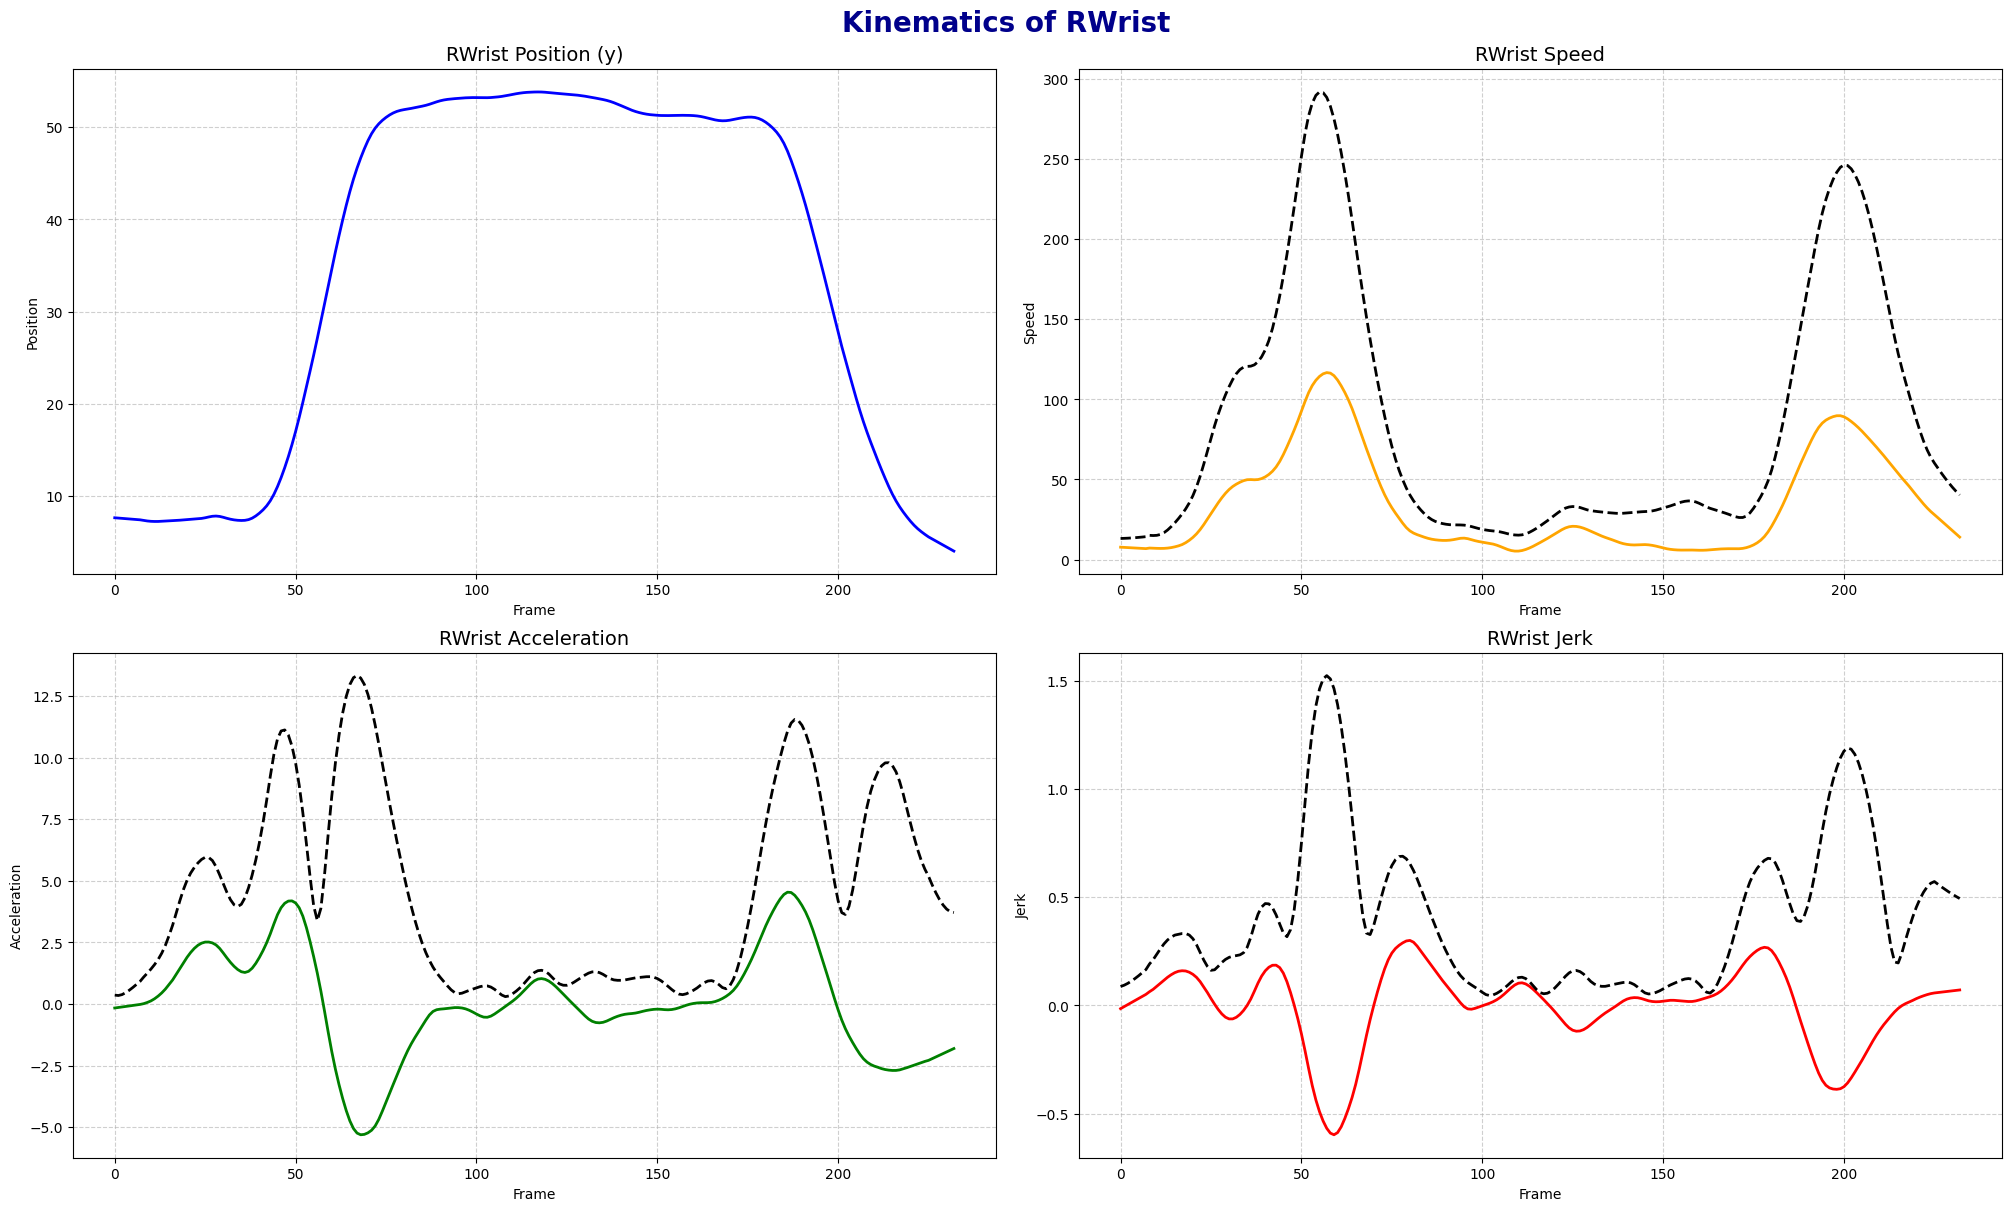

In [ ]:
#| echo: false

# Load one file to check
MTfiles = glob.glob(MTfolder_processed + '/*.csv')
print(MTfiles)
sample = pd.read_csv(MTfiles[4])

# Define colors and styles
colors = ['blue', 'orange', 'green', 'red']
titles = ['RWrist_y', 'RWrist_speed', 'RWrist_acc', 'RWrist_jerk']

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(20, 12), constrained_layout=True)
fig.suptitle('Kinematics of RWrist', fontsize=20, fontweight='bold', color='darkblue')

# Plot RWrist_y
axs[0, 0].plot(sample['RWrist_y'], color=colors[0], linewidth=2)
axs[0, 0].set_title('RWrist Position (y)', fontsize=14)
axs[0, 0].set_xlabel('Frame')
axs[0, 0].set_ylabel('Position')
axs[0, 0].grid(True, linestyle='--', alpha=0.6)

# Plot RWrist_speed
axs[0, 1].plot(sample['RWrist_speed'], color=colors[1], linewidth=2)
# add arm sum
axs[0, 1].plot(sample['arm_speedKin_sum'], color='black', linewidth=2, linestyle='--')
axs[0, 1].set_title('RWrist Speed', fontsize=14)
axs[0, 1].set_xlabel('Frame')
axs[0, 1].set_ylabel('Speed')
axs[0, 1].grid(True, linestyle='--', alpha=0.6)

# Plot RWrist_acc
axs[1, 0].plot(sample['RWrist_acc'], color=colors[2], linewidth=2)
# add arm sum
axs[1, 0].plot(sample['arm_accKin_sum'], color='black', linewidth=2, linestyle='--')
axs[1, 0].set_title('RWrist Acceleration', fontsize=14)
axs[1, 0].set_xlabel('Frame')
axs[1, 0].set_ylabel('Acceleration')
axs[1, 0].grid(True, linestyle='--', alpha=0.6)

# Plot RWrist_jerk
axs[1, 1].plot(sample['RWrist_jerk'], color=colors[3], linewidth=2)
# add arm sum
axs[1, 1].plot(sample['arm_jerkKin_sum'], color='black', linewidth=2, linestyle='--')
axs[1, 1].set_title('RWrist Jerk', fontsize=14)
axs[1, 1].set_xlabel('Frame')
axs[1, 1].set_ylabel('Jerk')
axs[1, 1].grid(True, linestyle='--', alpha=0.6)

# Adjust spacing
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Show the plot
plt.show()